In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-04-0fc8940702f2'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [5]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

bq_df = bpd.read_gbq(f'{project_id}.{dataset_name}.{table_name}')
bq_df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,94962,889,1,18.0
1,42612,764,1,259.98999
2,75420,739,1,149.0
3,57134,892,5,189.306
4,7072,1027,3,16.66
5,14834,976,4,35.370001
6,4204,735,1,53.98
7,42905,1005,1,54.18
8,85489,969,1,34.900002
9,61899,834,1,12.0


In [6]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

df_train, df_test = train_test_split(bq_df, test_size=0.2, random_state=42)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)
kmeans.to_gbq(f'{project_id}.{dataset_name}.{model_name}')

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [7]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,1,"[{'CENTROID_ID': 1, 'DISTANCE': 2.513706587733...",57134,892,5,189.306
10,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.129204754906...",44899,722,1,39.990002
23,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.132376504527...",20741,888,1,99.989998
24,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.899494201205...",65248,884,1,55.0
27,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.342625119709...",53642,729,1,9.95
30,1,"[{'CENTROID_ID': 1, 'DISTANCE': 2.079697460454...",66402,1062,4,62.7225
31,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.163770823984...",26626,913,4,46.1825
50,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.310179251740...",61492,734,2,13.99
56,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.628767496141...",68860,1037,1,45.0
57,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.062412550174...",22907,1075,1,25.0


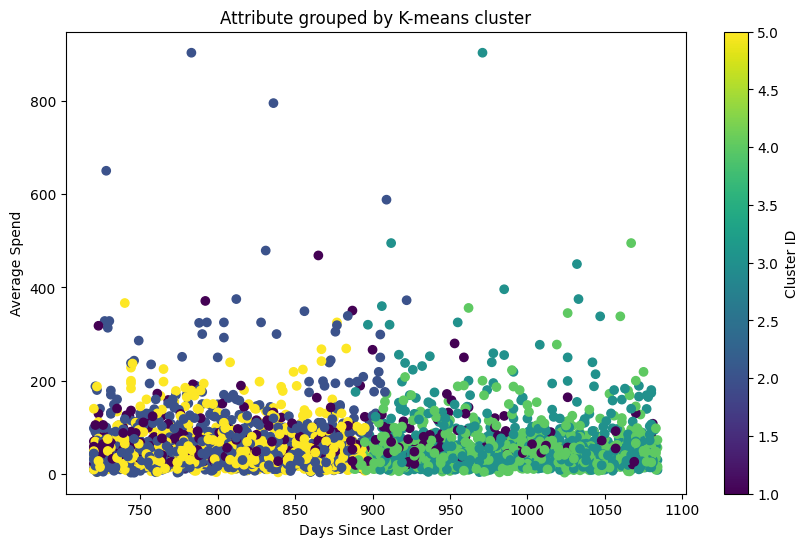

In [9]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='Cluster ID')
plt.show()

In [10]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,69.12,3.70,852.87
1,cluster 2,61.92,1.33,799.98
2,cluster 3,58.79,1.29,988.17
3,cluster 4,54.27,1.32,983.29
4,cluster 5,55.61,1.29,803.04


In [11]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $69.12, count of orders per person 3.7, days since last order 852.87
cluster 2, average spend $61.92, count of orders per person 1.33, days since last order 799.98
cluster 3, average spend $58.79, count of orders per person 1.29, days since last order 988.17
cluster 4, average spend $54.27, count of orders per person 1.32, days since last order 983.29
cluster 5, average spend $55.61, count of orders per person 1.29, days since last order 803.04


In [12]:
model = GenerativeModel("gemini-1.0-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 800,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

## Creative Brand Personas and Marketing Strategies for Each Customer Cluster:

**Cluster 1:**

* **Title:** The Loyal Lapsed
* **Persona:** These customers have a history of placing multiple orders with an average spend of $69.12. However, they haven't purchased anything in the last 852.87 days. They are likely satisfied with past purchases but may have found alternatives or simply forgotten about your brand.
* **Next Marketing Step:** 
    1. **Re-engagement campaign:** Send personalized emails or targeted ads reminding them of their past purchases and highlighting new products or promotions that might interest them. 
    2. **Offer exclusive discounts or loyalty rewards:** incentivize them to return with special offers or points for their next purchase.
    3. **Personalized product recommendations:** Based on their past purchases, suggest similar items or complementary products they might enjoy.

**Cluster 2:**

* **Title:** The One-Time Wonder
* **Persona:** These customers have o